# Sentiment Analysis using the IMDb reviews dataset - RNN-based model with attention/transformers mechanisms

Ref.

Kaggle

[Sentiment Analysis of IMDB Movie Reviews - gold](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews)

[Sentiment Analysis of IMDB Movie Reviews - cooper](https://www.kaggle.com/code/bhavikjikadara/sentiment-analysis-of-imdb-movie-reviews)

[IMDB Dataset Sentiment Analysis using RNN](https://www.kaggle.com/code/tanyildizderya/imdb-dataset-sentiment-analysis-using-rnn)

Keras

[Keras - IMDB movie review sentiment classification dataset](https://keras.io/api/datasets/imdb/)

這是一個包含 25,000 部電影評論的 IMDB 數據集，按情感（正面/負面）進行標記。評論已經過預處理，每個評論都被編碼為一個詞索引列表（整數）。為了方便起見，詞彙按照數據集中的整體頻率進行索引，因此例如整數 "3" 編碼了數據中第三個最常見的詞。這使得可以快速進行過濾操作，例如："只考慮前 10,000 個最常見的詞，但排除前 20 個最常見的詞"。

按照慣例，"0" 不代表特定的詞，而是用於編碼填充標記。

Benchmark

[Sentiment Analysis on IMDb](https://paperswithcode.com/sota/sentiment-analysis-on-imdb)

In [20]:
# Python version: 3.10.6

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn import metrics
import numpy as np
import pandas as pd

import keras
from keras import layers, losses, optimizers
from keras_preprocessing.sequence import pad_sequences
from keras.datasets import imdb
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import nltk
from nltk.tokenize.toktok import ToktokTokenizer

tf.config.list_physical_devices("GPU")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9866080591906230854
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 18478489396
locality {
  bus_id: 1
}
incarnation: 2034699411910385002
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15569762240
locality {
  bus_id: 1
}
incarnation: 13348634053460118536
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [21]:
start_char = 1
oov_char = 2
index_from = 3

num_epochs = 5
batch_size = 64
validation_split = 0.1
sequence_max_length = 3
# sequence_max_length = 500

num_words = 3
# num_words = 1000

## Load dataset

In [22]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=num_words,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

## EDA

In [23]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test.shape)

Training data shape: (25000,)
Training label shape: (25000,)
Test data shape: (25000,)
Test label shape: (25000,)


In [24]:
unique, counts = np.unique(y_train, return_counts=True)
print("y train distribution: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y test distribution: ", dict(zip(unique, counts)))

y train distribution:  {0: 12500, 1: 12500}
y test distribution:  {0: 12500, 1: 12500}


In [25]:
def print_decoded_sequence(data, index=0):
    # 取得字典 mapping => { word: index ...}
    word_index = imdb.get_word_index()

    # key, value => word, index
    inverted_word_index = dict((index + index_from, word) for (word, index) in word_index.items())

    # Update `inverted_word_index` to include `start_char` and `oov_char`
    inverted_word_index[0] = "[MASK]"
    inverted_word_index[start_char] = "[START]"
    inverted_word_index[oov_char] = "[OOV]"

    # X data (word sequence)

    print(data[index])
    decoded_sequence = " ".join(inverted_word_index[i] for i in data[index])
    print(decoded_sequence)

    # y data (labels: positive or negative)

    print(y_train[index])

In [26]:
print_decoded_sequence(x_train)

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[START] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] the [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OO

Text(0.5, 1.0, 'y train')

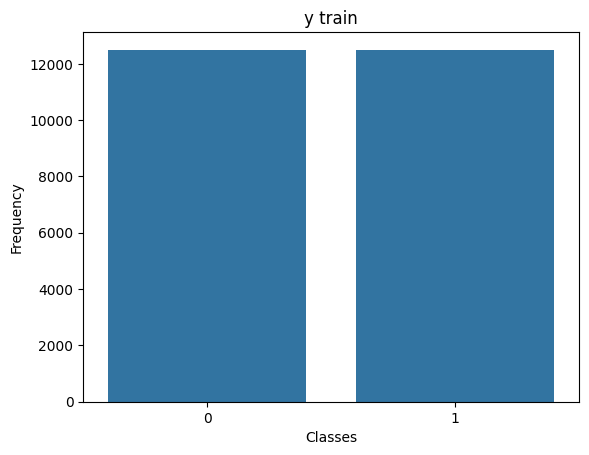

In [27]:
# training label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_train, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y train")

Text(0.5, 1.0, 'y test')

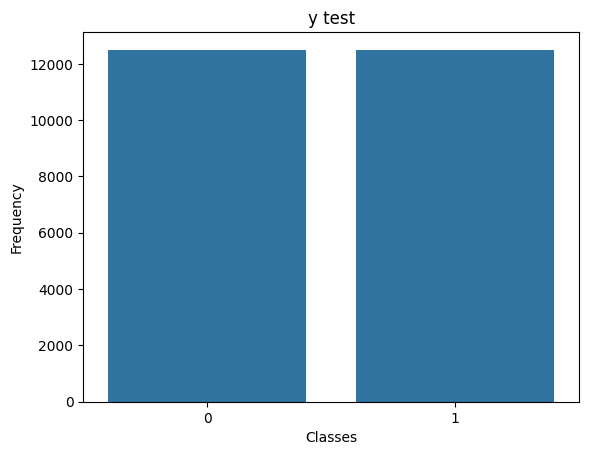

In [28]:
# test label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_test, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y test")

In [29]:
# words distribution


def visualize_sequence_distribution(x_train, x_test):
    review_len_train = []
    review_len_test = []
    for i, j in zip(x_train, x_test):
        review_len_train.append(len(i))
        review_len_test.append(len(j))

    print("min:", min(review_len_train), "max:", max(review_len_train))
    print("min:", min(review_len_test), "max:", max(review_len_test))

    sns.displot(review_len_train, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review train")
    sns.displot(review_len_test, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review test")

min: 11 max: 2494
min: 7 max: 2315


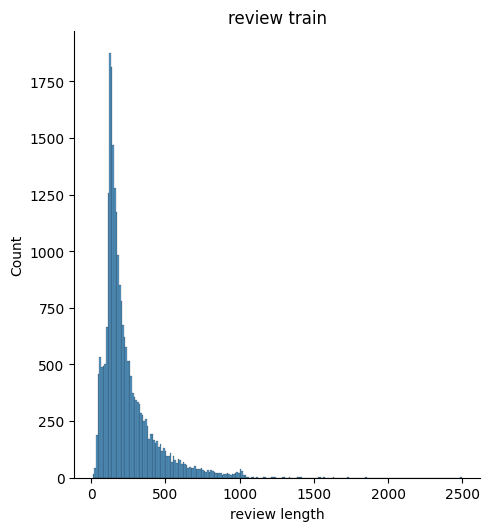

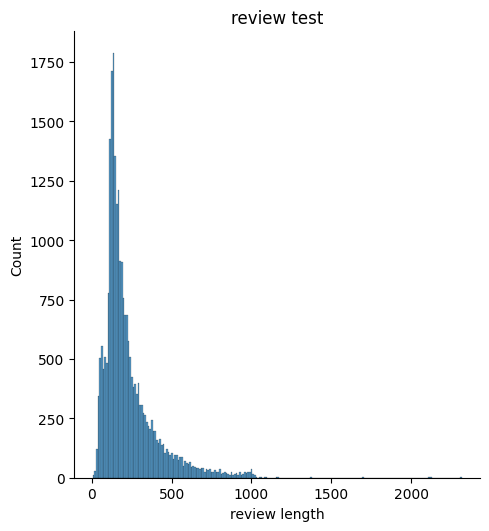

In [30]:
visualize_sequence_distribution(x_train, x_test)

## Data preprocessing

Keras's IMDB

X data : 資料已經預處理過，包括
* normalization => setting English stopwords
* removing html strips and noise text
* removing special characters
* segmentation (斷詞)
* removing stopwords
* encoding (編碼)

y data : 代表正向 (positive) 或負向 (negative) 的評論

In [31]:
# 使每個 sequence 有相同的長度

x_train = pad_sequences(x_train, maxlen=sequence_max_length)
x_test = pad_sequences(x_test, maxlen=sequence_max_length)

In [32]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test.shape)

Training data shape: (25000, 5)
Training label shape: (25000,)
Test data shape: (25000, 5)
Test label shape: (25000,)


min: 5 max: 5
min: 5 max: 5


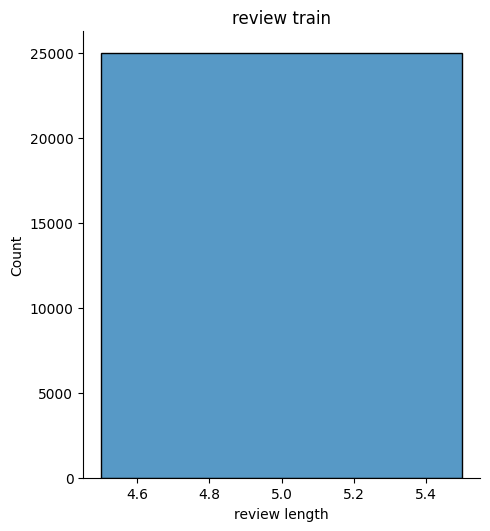

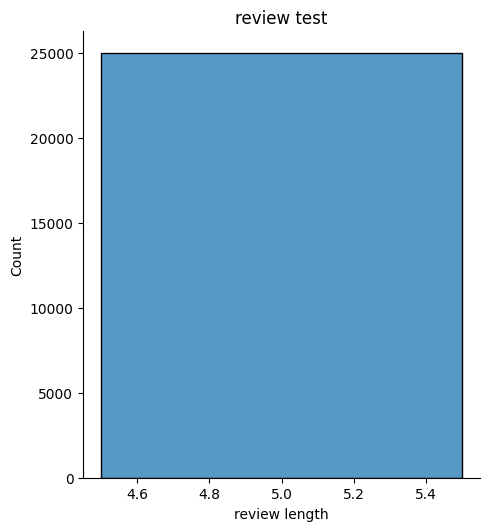

In [33]:
visualize_sequence_distribution(x_train, x_test)

In [34]:
print_decoded_sequence(x_train)

[2 2 2 2 2]
[OOV] [OOV] [OOV] [OOV] [OOV]
1


## RNN mechanism

Ref.

[一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)

![rnn](./images/rnn.png)

S<sub>t</sub> 代表神經元在 t 時刻上，同時接收
* 輸入 X 與其輸入權重 U
* 前一次 S 在 t-1 時刻的 S<sub>t-1</sub> 與其 W (S<sub>t-1</sub> --> S<sub>t</sub> 的權重)

展開

![rnn-expand](./images/rnn-expand.png)

## Attention mechanism

Ref.

[完全解析RNN, Seq2Seq, Attention注意力机制](https://zhuanlan.zhihu.com/p/51383402)

[A simple overview of RNN, LSTM and Attention Mechanism](https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b)

[注意力機制 (Attention Mechanism) 的理解與實作](https://www.kaggle.com/code/lianghsunhuang/attention-mechanism)

Attention 的架構

![attention-mechanism](./images/attention-mechanism.png)

## Build model

Ref.

[Keras 中的循环神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn?hl=zh-cn)

[Keras实现CNN、RNN（基于attention 的双向RNN）及两者的融合](https://blog.csdn.net/xwd18280820053/article/details/80060544)

[Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

In [35]:
class BaseRNN(keras.Model):

    def __init__(self, **kwargs):

        super(BaseRNN, self).__init__()

        self.embedding = layers.Embedding(num_words, 64, mask_zero=True)
        self.rnn = layers.SimpleRNN(64)
        self.dense_1 = layers.Dense(64, activation="relu")
        self.final_output = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training=False):
        x = self.embedding(inputs, training=training)
        x = self.rnn(x, training=training)
        x = self.dense_1(x, training=training)
        x = self.final_output(x, training=training)
        return x


# class BidiectionalRNNwithAttention(keras.Model):

#     def __init__(self, **kwargs):

#         super(BidiectionalRNNwithAttention, self).__init__(**kwargs)

#     def call(self, inputs, training=False):
#         pass

## Preview model

In [36]:
rnn = BaseRNN()
rnn.build(input_shape=(None, sequence_max_length))
rnn.call(layers.Input((sequence_max_length)))
rnn.summary()

Model: "base_rnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 64)             320       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________


In [37]:
rnn.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer=optimizers.Adam(), metrics=["accuracy"])

## Train model

In [38]:
train_history = rnn.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    verbose=0,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[TqdmCallback(verbose=0)],
)

0epoch [00:00, ?epoch/s]

## Evaluation

## Save result

## Final prediction

## Test result insights